# Anomaly Detection Based on Titanic Dataset

# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Classical Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Advanced Model
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# Generate Synthetic Titanic-Like Data

# 2. Load and Explore the Data

In [2]:
df = pd.read_csv("titanic_synthetic.csv")
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

   Pclass     Sex        Age  SibSp  Parch        Fare Embarked  Survived
0       3  female  27.897474      1      5   22.586915        C         1
1       1    male  41.614200      3      1  130.681821        S         0
2       3    male  27.353955      3      4   49.341796        S         0
3       3    male  25.180209      5      4   54.049767        C         0
4       1    male  22.843518      2      5  240.488833        C         0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409856 entries, 0 to 409855
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Pclass    409856 non-null  int64  
 1   Sex       409856 non-null  object 
 2   Age       409856 non-null  float64
 3   SibSp     409856 non-null  int64  
 4   Parch     409856 non-null  int64  
 5   Fare      409856 non-null  float64
 6   Embarked  409856 non-null  object 
 7   Survived  409856 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory

# 3. Data Preprocessing and Feature Engineering

In [3]:
# Encoding categorical variables
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

# Feature: Family Size
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Target and Features
X = df.drop('Survived', axis=1)
y = df['Survived']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# 4. Model Training and Evaluation

# 4.1. Helper Function

In [4]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{name}:\nAccuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("-" * 60)

 # 4.2. Models

In [5]:
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=4),
    #'SVM': SVC(kernel='rbf', probability=True),
    #'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}
for name, model in models.items():
    evaluate_model(name, model, X_train, X_test, y_train, y_test)
best_model = models['XGBoost']
best_model.fit(X_train, y_train)

Logistic Regression:
Accuracy: 0.4987, F1 Score: 0.4293
              precision    recall  f1-score   support

           0       0.50      0.62      0.55     41065
           1       0.50      0.38      0.43     40907

    accuracy                           0.50     81972
   macro avg       0.50      0.50      0.49     81972
weighted avg       0.50      0.50      0.49     81972

[[25427 15638]
 [25454 15453]]
------------------------------------------------------------
KNN:
Accuracy: 0.4995, F1 Score: 0.4978
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     41065
           1       0.50      0.50      0.50     40907

    accuracy                           0.50     81972
   macro avg       0.50      0.50      0.50     81972
weighted avg       0.50      0.50      0.50     81972

[[20612 20453]
 [20576 20331]]
------------------------------------------------------------
Decision Tree:
Accuracy: 0.5006, F1 Score: 0.0056
              pr

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# 5. Test Set Preparation

In [6]:
# Loading test dataset (409,856 rows)
test_df = pd.read_csv("titanic_synthetic.csv")

# Encoding categorical variables
test_df = pd.get_dummies(test_df, columns=['Sex', 'Embarked'], drop_first=True)

# Feature: Family Size
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

# Aligning test set columns with training set
missing_cols = set(X.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0
test_df = test_df[X.columns]  # Ensure same order

# Scale
X_final_test = scaler.transform(test_df)

# 6. Prediction and Submission File Creation

In [9]:
# Making predictions on preprocessed test set
predictions = best_model.predict(X_final_test)

submission = pd.DataFrame({
    'id': range(1, len(predictions) + 1),
    'anomaly': predictions
})

submission.to_csv("submission.csv", index=False)


# 7. Exploratory Data Visualization

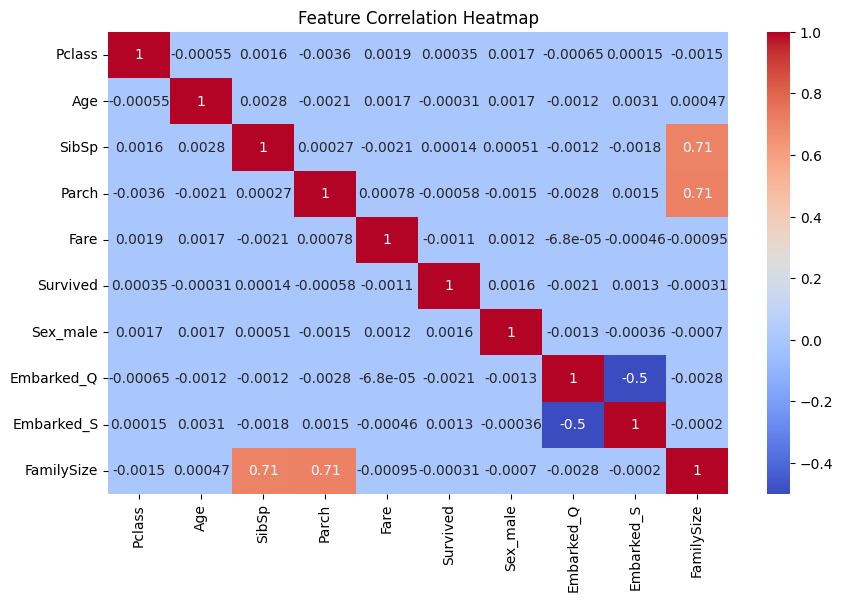

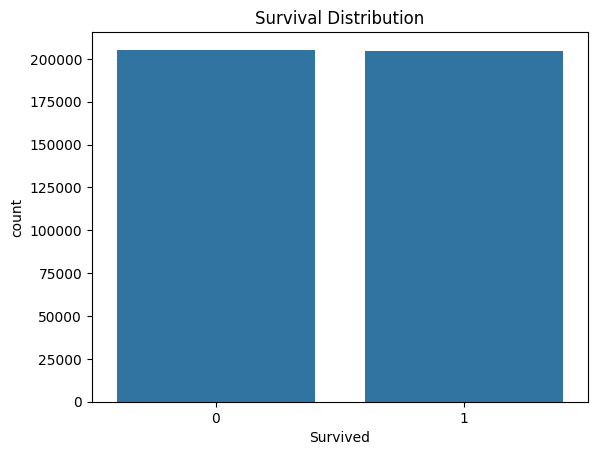

In [7]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Survival count
sns.countplot(x='Survived', data=df)
plt.title("Survival Distribution")
plt.show()
